<a href="https://colab.research.google.com/github/Saihaj-coder/M2CLIP-SEmoNet/blob/main/CLIP_Memotion2_M1(TaskA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
train_dataset = pd.read_csv('/content/drive/MyDrive/Memotion2/memotion_train.csv')
train_dataset

,Id,Image url,ocr_text,humour,sarcastic,offensive,motivational,overall_sentiment,classification_based_on
0,1,https://preview.redd.it/9jkzlvt8p4q31.jpg?widt...,enters into a wrong class teacher and students,funny,not_sarcastic,slight,not_motivational,neutral,image_and_text
1,2,https://i.pinimg.com/originals/fd/c8/e2/fdc8e2...,dj if you single make some nooooissssseeee my ...,funny,not_sarcastic,not_offensive,not_motivational,neutral,image_and_text
2,3,https://i.pinimg.com/originals/85/10/13/851013...,everyone sit like a lady me,funny,not_sarcastic,slight,not_motivational,neutral,image_and_text
3,4,https://i.imgur.com/07ZcrjZ_d.webp?maxwidth=52...,when youre about to watch a 2 hour educational...,funny,not_sarcastic,not_offensive,not_motivational,neutral,image_and_text
4,5,https://i.imgur.com/MGddJxr_d.jpg?maxwidth=520...,government work from home olympic swimmers nsdf,very_funny,little_sarcastic,not_offensive,not_motivational,neutral,image_and_text
...,...,...,...,...,...,...,...,...,...
6995,6996,https://i.imgur.com/GVMItaW_d.webp?maxwidth=52...,my plan my budget,very_funny,little_sarcastic,not_offensive,not_motivational,positive,image_and_text
6996,6997,https://i.pinimg.com/originals/f1/bd/ec/f1bdec...,emoji scissors wouldnt close in real life inte...,funny,very_sarcastic,slight,not_motivational,neutral,image_and_text
6997,6998,https://pics.me.me/thumb_every-time-by-moosa97...,me ready to get a good nights sleep my left no...,funny,little_sarcastic,not_offensive,not_motivational,positive,image_and_text
6998,6999,https://i.imgur.com/LQY8dd4_d.jpg?maxwidth=520...,you get new brain wrinkles when you learn some...,funny,not_sarcastic,not_offensive,not_motivational,neutral,image_and_text


In [ ]:
train_dataset['overall_sentiment'] = train_dataset['overall_sentiment'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

<ipython-input-4-7787e5163934>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_dataset['overall_sentiment'] = train_dataset['overall_sentiment'].replace({


In [ ]:
train_dataset['overall_sentiment'].value_counts()

,count
overall_sentiment,
1,4510
2,1517
0,973


In [ ]:
val_dataset = pd.read_csv('/content/drive/MyDrive/Memotion2/memotion_val.csv')
val_dataset

,Id,Image url,ocr_text,humour,sarcastic,offensive,motivational,overall_sentiment,classification_based_on
0,1,https://i.pinimg.com/originals/35/e7/9b/35e79b...,guy in math problem choosing shape for lawn na...,very_funny,little_sarcastic,not_offensive,not_motivational,neutral,image_and_text
1,2,https://i.imgur.com/rEoQC6p_d.webp?maxwidth=52...,анннн омg something touched me,very_funny,little_sarcastic,not_offensive,not_motivational,neutral,text
2,3,https://i.imgur.com/KOKQrQZ_d.webp?maxwidth=52...,when you accidentally touch your sense of humor,very_funny,not_sarcastic,not_offensive,not_motivational,neutral,image_and_text
3,4,https://pics.me.me/thumb_me-irl-by-anitawin-15...,me when i get me explaining why angry i got an...,very_funny,very_sarcastic,not_offensive,not_motivational,neutral,image_and_text
4,5,https://i.imgur.com/BzBsaAV_d.jpg?maxwidth=520...,me pretending im listening but im actually thi...,funny,not_sarcastic,not_offensive,not_motivational,neutral,image_and_text
...,...,...,...,...,...,...,...,...,...
1495,1496,https://i.imgur.com/pPLi5dx_d.jpg?maxwidth=520...,yachtys new hairdo is 0 cheetos,not_funny,little_sarcastic,slight,not_motivational,neutral,image_and_text
1496,1497,https://encrypted-tbn0.gstatic.com/images?q=tb...,nazi zombies cci gang ci gang cci gang jcci ga...,very_funny,little_sarcastic,not_offensive,not_motivational,neutral,image_and_text
1497,1498,https://i.imgur.com/rqmx4p2_d.webp?maxwidth=52...,when youre born after the different jurisdicti...,not_funny,extremely_sarcastic,not_offensive,not_motivational,neutral,image_and_text
1498,1499,https://i.pinimg.com/originals/55/27/71/552771...,thinking about how many pizza slices you can e...,very_funny,little_sarcastic,not_offensive,not_motivational,neutral,image_and_text


In [ ]:
val_dataset['overall_sentiment'] = val_dataset['overall_sentiment'].replace({
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'negative': 0})

<ipython-input-7-1cf8695dfed7>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_dataset['overall_sentiment'] = val_dataset['overall_sentiment'].replace({


In [ ]:
val_dataset['overall_sentiment'].value_counts()

,count
overall_sentiment,
1,975
2,325
0,200


In [ ]:
# Define custom dataset class
class MemeDataset(Dataset):
    def __init__(self, images, captions, sentiments, tokenizer, image_transforms, image_dir):
        self.images = images
        self.captions = captions
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.image_dir, image_name)
        caption = self.captions[idx]
        sentiment = self.sentiments[idx]

        # Load and preprocess image
        image = cv2.imread(image_path)
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)  # Create a blank image

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.image_transforms(image=image)['image']
        image = torch.tensor(image).permute(2, 0, 1).float()

        # Ensure caption is a string
        if not isinstance(caption, str):
            caption = str(caption)

        if isinstance(caption, list):
            caption = ' '.join(caption)

        if not caption:
            caption = "empty caption"

        # Encode caption
        encoded_caption = self.tokenizer([caption], return_tensors="pt", padding='max_length', truncation=True, max_length=77)
        input_ids = encoded_caption['input_ids'].squeeze()
        attention_mask = encoded_caption['attention_mask'].squeeze()

        sentiment_class = torch.tensor(sentiment)

        return {'image': image, 'input_ids': input_ids, 'attention_mask': attention_mask, 'sentiment': sentiment_class}

# Define custom model with CLIP and dense layers
class CustomCLIPModel(nn.Module):
    def __init__(self, clip_model):
        super(CustomCLIPModel, self).__init__()
        self.clip_model = clip_model

        for param in self.clip_model.parameters():
            param.requires_grad = True

        self.fc1 = nn.Linear(1024, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.4)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.dropout3 = nn.Dropout(0.4)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 3)
        self.gelu = nn.GELU()

    def forward(self, image, input_ids, attention_mask):
        text_features = self.clip_model.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        image_features = self.clip_model.get_image_features(pixel_values=image)

        text_features = torch.nn.functional.normalize(text_features, dim=1)
        image_features = torch.nn.functional.normalize(image_features, dim=1)

        combined_features = torch.cat((text_features, image_features), dim=1)

        x = self.fc1(combined_features)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.gelu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.gelu(x)
        x = self.dropout3(x)
        logits = self.fc4(x)

        return logits, image_features, text_features

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.cross_entropy_loss = nn.CrossEntropyLoss()

    def forward(self, logits, labels):
        ce_loss = self.cross_entropy_loss(logits, labels)
        return ce_loss


def train_epoch(model, train_loader, optimizer, device, criterion):
    model.train()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm_object:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        optimizer.zero_grad()
        logits, image_features, text_features = model(images, input_ids, attention_mask)
        loss = criterion(logits, sentiments)
        loss.backward()
        optimizer.step()

        count = images.size(0)
        loss_meter.update(loss.item(), count)

        preds = logits.argmax(dim=1)
        correct_predictions += (preds == sentiments).sum().item()
        total_predictions += sentiments.size(0)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    accuracy = correct_predictions / total_predictions
    return loss_meter, accuracy

def evaluate(model, data_loader, device, criterion):
    model.eval()
    predictions, true_labels = [], []
    loss_meter = AvgMeter()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)

            logits, image_features, text_features = model(images, input_ids, attention_mask)
            loss = criterion(logits, sentiments)

            loss_meter.update(loss.item(), len(images))

            preds = logits.argmax(dim=1)
            correct_predictions += (preds == sentiments).sum().item()
            total_predictions += sentiments.size(0)

            true = sentiments.cpu().numpy()
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(true)

    accuracy = correct_predictions / total_predictions
    return predictions, true_labels, loss_meter.avg, accuracy

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


train_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(p=0.2),  # Added augmentation
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

model = CustomCLIPModel(clip_model)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


train_image_dir = '/content/drive/MyDrive/Memotion2/image folder/train_images'
val_image_dir = '/content/drive/MyDrive/Memotion2/image folder/val_images'

train_dataset = MemeDataset(
    images=train_dataset['Image url'].tolist(),
    captions=train_dataset['ocr_text'].tolist(),
    sentiments=train_dataset['overall_sentiment'].tolist(),
    tokenizer=processor.tokenizer,
    image_transforms=train_image_transforms,
    image_dir=train_image_dir
)

val_dataset = MemeDataset(
    images=val_dataset['Image url'].tolist(),
    captions=val_dataset['ocr_text'].tolist(),
    sentiments=val_dataset['overall_sentiment'].tolist(),
    tokenizer=processor.tokenizer,
    image_transforms=val_image_transforms,
    image_dir=val_image_dir
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay = 1e-3)
num_epochs = 5


scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

# Loss functions
criterion = CustomLoss()
# contrastive_criterion = ContrastiveLoss(temperature=0.07)

BEST_MODEL_PATH = 'best_model.pth'

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_accuracy = 0

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, 'cuda' if torch.cuda.is_available() else 'cpu', criterion)
    val_predictions, val_true_labels, val_loss, val_accuracy = evaluate(model, val_loader, 'cuda' if torch.cuda.is_available() else 'cpu', criterion)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), BEST_MODEL_PATH)

    train_losses.append(train_loss.avg)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss.avg}, Train Accuracy: {train_accuracy}")
    print(f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

    scheduler.step()

model.load_state_dict(torch.load(BEST_MODEL_PATH))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/5


100%|██████████| 219/219 [02:23<00:00,  1.52it/s, lr=1e-5, train_loss=1.13]


Train Loss: 1.1254547292164394, Train Accuracy: 0.37114285714285716
Val Loss: 1.0579990275700888, Val Accuracy: 0.458
Epoch 2/5


100%|██████████| 219/219 [01:53<00:00,  1.92it/s, lr=9.99e-6, train_loss=1.08]


Train Loss: 1.0784339714050293, Train Accuracy: 0.4217142857142857
Val Loss: 1.0394800437291463, Val Accuracy: 0.5026666666666667
Epoch 3/5


100%|██████████| 219/219 [01:54<00:00,  1.92it/s, lr=9.98e-6, train_loss=1.04]


Train Loss: 1.0392752836772374, Train Accuracy: 0.47114285714285714
Val Loss: 1.0411567233403525, Val Accuracy: 0.49066666666666664
Epoch 4/5


100%|██████████| 219/219 [01:53<00:00,  1.92it/s, lr=9.97e-6, train_loss=1.01]


Train Loss: 1.0067963760920933, Train Accuracy: 0.5072857142857143
Val Loss: 1.0139776096343993, Val Accuracy: 0.5606666666666666
Epoch 5/5


100%|██████████| 219/219 [01:55<00:00,  1.90it/s, lr=9.96e-6, train_loss=0.965]


Train Loss: 0.9650784802436828, Train Accuracy: 0.5472857142857143
Val Loss: 1.014720949490865, Val Accuracy: 0.5446666666666666


<ipython-input-9-daa3eff907be>:272: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BEST_MODEL_PATH))


<All keys matched successfully>

In [ ]:

# Evaluate on validation set to calculate metrics
from sklearn.metrics import f1_score, classification_report

val_predictions, val_true_labels, val_loss, val_accuracy = evaluate(model, val_loader,  'cuda' if torch.cuda.is_available() else 'cpu', criterion)

f1_weighted = f1_score(val_true_labels, val_predictions, average='weighted')
f1_macro = f1_score(val_true_labels, val_predictions, average='macro')
class_report = classification_report(val_true_labels, val_predictions)

print(f'Best Validation Accuracy: {best_val_accuracy}')
print(f'F1 Weighted: {f1_weighted:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')
print(f'Classification Report:\n{class_report}')

Best Validation Accuracy: 0.5606666666666666
F1 Weighted: 0.5152
F1 Macro: 0.3181
Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.04      0.06       200
           1       0.66      0.81      0.72       975
           2       0.21      0.15      0.17       325

    accuracy                           0.56      1500
   macro avg       0.32      0.33      0.32      1500
weighted avg       0.49      0.56      0.52      1500



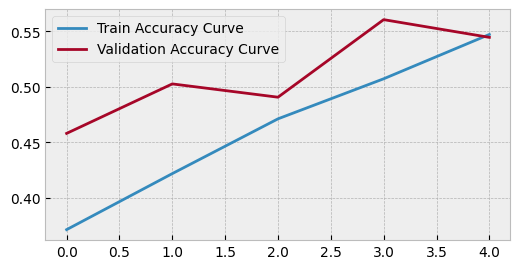

In [ ]:
plt.style.use('bmh')
plt.figure(figsize=(6,3))
plt.plot(train_accuracies, label='Train Accuracy Curve')
plt.plot(val_accuracies, label='Validation Accuracy Curve')
plt.legend()
plt.show()